# Example Analysis

*CLARITE facilitates the quality control and analysis process for EWAS of metabolic-related traits*

Data from NHANES was used in an EWAS analysis including utilizing the provided survey weight information.  The first two cycles of NHANES (1999-2000 and 2001-2002) are assigned to a 'discovery' dataset and the next two cycles (2003-2004 and 2005-2006) are assigned to a 'replication' datset.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import clarite

In [2]:
pd.options.display.max_rows = 10
pd.options.display.max_columns = 6

## Load Data

In [3]:
data_folder = "../../../../data/NHANES_99-06/"
data_main_table_over18 = data_folder + "MainTable_keepvar_over18.tsv"
data_main_table = data_folder + "MainTable.csv"
data_var_description = data_folder + "VarDescription.csv"
data_var_categories = data_folder + "VarCat_nopf.txt"
output = "output"

### Data of all samples with age >= 18

In [4]:
# Data
nhanes = clarite.load.from_tsv(data_main_table_over18, index_col="ID")
nhanes.head()

Loaded 22,624 observations of 970 variables


,RIDAGEYR,female,black,...,LBXV4E,LBXVTE,occupation
ID,,,,,,,
2,77,0,0,...,NaN,NaN,1.0
5,49,0,0,...,NaN,NaN,NaN
6,19,1,0,...,NaN,NaN,2.0
7,59,1,1,...,NaN,NaN,NaN
10,43,0,1,...,NaN,NaN,4.0


### Variable Descriptions

In [5]:
var_descriptions = pd.read_csv(data_var_description)[["tab_desc","module","var","var_desc"]]\
                     .drop_duplicates()\
                     .set_index("var")
var_descriptions.head()

,tab_desc,module,var_desc
var,,,
LBXHBC,"Hepatitis A, B, C and D",laboratory,Hepatitis B core antibody
LBDHBG,"Hepatitis A, B, C and D",laboratory,Hepatitis B surface antigen
LBDHCV,"Hepatitis A, B, C and D",laboratory,Hepatitis C antibody (confirmed)
LBDHD,"Hepatitis A, B, C and D",laboratory,Hepatitis D (anti-HDV)
LBXHBS,Hepatitis B Surface Antibody,laboratory,Hepatitis B Surface Antibody


In [6]:
# Convert variable descriptions to a dictionary for convenience
var_descr_dict = var_descriptions["var_desc"].to_dict()

### Survey Weights, as provided by NHANES

Survey weight information is used so that the results apply to the US civillian non-institutionalized population.

This includes:

  * SDMVPSU (Cluster ID)
  * SDMVSTRA (Nested Strata ID)
  * 2-year weights
  * 4-year weights
  
Different variables require different weights, as many of them were measured on a subset of the full dataset.  For example:

  * *WTINT* is the survey weight for interview variables.
  * *WTMEC* is the survey weight for variables measured in the Mobile Exam Centers (a subset of interviewed samples)

2-year and 4-year weights are provided.  It is important to adjust the weights when combining multiple cycles, by computing the weighted average.  In this case 4-year weights (covering the first 2 cycles) are provided by NHANES and the replication weights (the 3rd and 4th cycles) were computed from the 2-year weights prior to loading them here.

In [7]:
survey_design_discovery = pd.read_csv(data_folder + "weights/weights_discovery.txt", sep="\t")\
                            .rename(columns={'SEQN':'ID'})\
                            .set_index("ID")\
                            .drop(columns="SDDSRVYR")
survey_design_discovery.head()

,SDMVPSU,SDMVSTRA,WTINT2YR,...,WTSVOC2Y,WTSAU2YR,WTUIO2YR
ID,,,,,,,
1,1,5,9727.078709,...,NaN,NaN,NaN
2,3,1,26678.636376,...,NaN,NaN,NaN
3,2,7,43621.680548,...,NaN,NaN,NaN
4,1,2,10346.119327,...,NaN,NaN,NaN
5,2,8,91050.846620,...,NaN,NaN,NaN


In [8]:
survey_design_replication = pd.read_csv(data_folder + "weights/weights_replication_4yr.txt", sep="\t")\
                            .rename(columns={'SEQN':'ID'})\
                            .set_index("ID")\
                            .drop(columns="SDDSRVYR")
survey_design_replication.head()

,SDMVPSU,SDMVSTRA,WTINT2YR,...,WTSOG2YR,WTSC2YRA,WTSPC2YR
ID,,,,,,,
21005,2,39,2756.160474,...,NaN,NaN,NaN
21006,1,41,2711.070226,...,NaN,NaN,NaN
21007,2,35,19882.088706,...,NaN,NaN,NaN
21008,1,32,2799.749676,...,NaN,NaN,NaN
21009,2,31,48796.839489,...,NaN,NaN,NaN


In [9]:
# These files map variables to their correct weights, and were compiled by reading throught the NHANES codebook
var_weights = pd.read_csv(data_folder + "weights/VarWeights.csv")
var_weights.head()

,variable_name,discovery,replication
0,99999,WTMEC4YR,WTMEC2YR
1,ACETAMINOPHEN__CODEINE,WTMEC4YR,WTMEC2YR
2,ACETAMINOPHEN__CODEINE_PHOSPHATE,WTMEC4YR,WTMEC2YR
3,ACETAMINOPHEN__HYDROCODONE,WTMEC4YR,WTMEC2YR
4,ACETAMINOPHEN__HYDROCODONE_BITARTRATE,WTMEC4YR,WTMEC2YR


In [10]:
# Convert the data to two dictionaries for convenience
weights_discovery = var_weights.set_index('variable_name')['discovery'].to_dict()
weights_replication = var_weights.set_index('variable_name')['replication'].to_dict()

### Survey Year data

Survey year is found in a separate file and can be matched using the *SEQN* ID value.

In [11]:
survey_year = pd.read_csv(data_main_table)[["SEQN", "SDDSRVYR"]].rename(columns={'SEQN':'ID'}).set_index("ID")
nhanes = clarite.modify.merge_variables(nhanes, survey_year, how="left")

Running merge_variables
--------------------------------------------------------------------------------
left Merge:
	left = 22,624 observations of 970 variables
	right = 41,474 observations of 1 variables
Kept 22,624 observations of 971 variables.


## Define the phenotype and covariates

In [12]:
phenotype = "BMXBMI"
print(f"{phenotype} = {var_descriptions.loc[phenotype, 'var_desc']}")
covariates = ["female", "black", "mexican", "other_hispanic", "other_eth", "SES_LEVEL", "RIDAGEYR", "SDDSRVYR"]

BMXBMI = Body Mass Index (kg/m**2)


## Initial cleanup / variable selection

### Remove any samples missing the phenotype or one of the covariates

In [13]:
nhanes = clarite.modify.rowfilter_incomplete_obs(nhanes, only=[phenotype] + covariates)

Running rowfilter_incomplete_obs
--------------------------------------------------------------------------------
Removed 3,687 of 22,624 observations (16.30%) due to NA values in any of 9 variables


### Remove variables that aren't appropriate for the analysis

#### Physical fitness measures

These are measurements rather than proxies for environmental exposures

In [14]:
phys_fitness_vars = ["CVDVOMAX","CVDESVO2","CVDS1HR","CVDS1SY","CVDS1DI","CVDS2HR","CVDS2SY","CVDS2DI","CVDR1HR","CVDR1SY","CVDR1DI","CVDR2HR","CVDR2SY","CVDR2DI","physical_activity"]
for v in phys_fitness_vars:
    print(f"\t{v} = {var_descr_dict[v]}")
nhanes = nhanes.drop(columns=phys_fitness_vars)

	CVDVOMAX = Predicted VO2max (ml/kg/min)
	CVDESVO2 = Estimated VO2max (ml/kg/min)
	CVDS1HR = Stage 1 heart rate (per min)
	CVDS1SY = Stage 1 systolic BP (mm Hg)
	CVDS1DI = Stage 1 diastolic BP (mm Hg)
	CVDS2HR = Stage 2 heart rate (per min)
	CVDS2SY = Stage 2 systolic BP (mm Hg)
	CVDS2DI = Stage 2 diastolic BP (mm Hg)
	CVDR1HR = Recovery 1 heart rate (per min)
	CVDR1SY = Recovery 1 systolic BP (mm Hg)
	CVDR1DI = Recovery 1 diastolic BP (mm Hg)
	CVDR2HR = Recovery 2 heart rate (per min)
	CVDR2SY = Recovery 2 systolic BP (mm Hg)
	CVDR2DI = Recovery 2 diastolic BP (mm Hg)
	physical_activity = Physical Activity (MET-based rank)


#### Lipid variables

These are likely correlated with BMI in some way

In [15]:
lipid_vars = ["LBDHDD", "LBDHDL", "LBDLDL", "LBXSTR", "LBXTC", "LBXTR"]
print("Removing lipid measurement variables:")
for v in lipid_vars:
    print(f"\t{v} = {var_descr_dict[v]}")
nhanes = nhanes.drop(columns=lipid_vars)

Removing lipid measurement variables:
	LBDHDD = Direct HDL-Cholesterol (mg/dL)
	LBDHDL = Direct HDL-Cholesterol (mg/dL)
	LBDLDL = LDL-cholesterol (mg/dL)
	LBXSTR = Triglycerides (mg/dL)
	LBXTC = Total cholesterol (mg/dL)
	LBXTR = Triglyceride (mg/dL)


#### Indeterminate variables

These variables don't have clear meanings

In [16]:
indeterminent_vars = ["house_type","hepa","hepb", "house_age", "current_past_smoking"]
print("Removing variables with indeterminate meanings:")
for v in indeterminent_vars:
    print(f"\t{v} = {var_descr_dict[v]}")
nhanes = nhanes.drop(columns=indeterminent_vars)

Removing variables with indeterminate meanings:
	house_type = house type
	hepa = hepatitis a
	hepb = hepatitis b
	house_age = house age
	current_past_smoking = Current or Past Cigarette Smoker?


### Recode "missing" values

In [17]:
# SMQ077 and DDB100 have Refused/Don't Know for "7" and "9"
nhanes = clarite.modify.recode_values(nhanes, {7: np.nan, 9: np.nan}, only=['SMQ077', 'DBD100'])

Running recode_values
--------------------------------------------------------------------------------
Replaced 11 values from 18,937 observations in 2 variables


### Split the data into *discovery* and *replication*

In [18]:
discovery = (nhanes['SDDSRVYR']==1) | (nhanes['SDDSRVYR']==2)
replication = (nhanes['SDDSRVYR']==3) | (nhanes['SDDSRVYR']==4)

nhanes_discovery = nhanes.loc[discovery]
nhanes_replication = nhanes.loc[replication]

In [19]:
nhanes_discovery.head()

,RIDAGEYR,female,black,...,LBXVTE,occupation,SDDSRVYR
ID,,,,,,,
2,77,0,0,...,NaN,1.0,1
5,49,0,0,...,NaN,NaN,1
6,19,1,0,...,NaN,2.0,1
12,37,0,0,...,NaN,4.0,1
13,70,0,0,...,NaN,4.0,1


In [20]:
nhanes_replication.head()

,RIDAGEYR,female,black,...,LBXVTE,occupation,SDDSRVYR
ID,,,,,,,
21005,19,0,1,...,NaN,4.0,3
21009,55,0,0,...,NaN,4.0,3
21010,52,1,0,...,NaN,2.0,3
21012,63,0,1,...,NaN,1.0,3
21015,83,0,0,...,NaN,1.0,3


## QC

### Minimum of 200 non-NA values in each variable

Drop variables that have too small of a sample size

In [21]:
nhanes_discovery = clarite.modify.colfilter_min_n(nhanes_discovery, skip=[phenotype] + covariates)
nhanes_replication = clarite.modify.colfilter_min_n(nhanes_replication, skip=[phenotype] + covariates)

Running colfilter_min_n
--------------------------------------------------------------------------------
Testing 0 of 0 binary variables
Testing 0 of 0 categorical variables
Testing 936 of 945 continuous variables
	Removed 302 (32.26%) tested continuous variables which had less than 200 non-null values.
Running colfilter_min_n
--------------------------------------------------------------------------------
Testing 0 of 0 binary variables
Testing 0 of 0 categorical variables
Testing 936 of 945 continuous variables
	Removed 225 (24.04%) tested continuous variables which had less than 200 non-null values.


### Categorize Variables

This is important, as different variable types must be processed in different ways.  The number of unique values for each variable is a good heuristic for determining this.  The default settings were used here, but different cutoffs can be specified.  CLARITE reports the results in neatly formatted text:

In [22]:
nhanes_discovery = clarite.modify.categorize(nhanes_discovery)
nhanes_replication = clarite.modify.categorize(nhanes_replication)

Running categorize
--------------------------------------------------------------------------------
229 of 643 variables (35.61%) are classified as binary (2 unique values).
19 of 643 variables (2.95%) are classified as categorical (3 to 6 unique values).
336 of 643 variables (52.26%) are classified as continuous (>= 15 unique values).
37 of 643 variables (5.75%) were dropped.
	0 variables had zero unique values (all NA).
	37 variables had one unique value.
22 of 643 variables (3.42%) were not categorized and need to be set manually.
	22 variables had between 6 and 15 unique values
	0 variables had >= 15 values but couldn't be converted to continuous (numeric) values
Running categorize
--------------------------------------------------------------------------------
236 of 720 variables (32.78%) are classified as binary (2 unique values).
32 of 720 variables (4.44%) are classified as categorical (3 to 6 unique values).
400 of 720 variables (55.56%) are classified as continuous (>= 15 un

### Checking categorization

#### Distributions of variables may be plotted using CLARITE:

``` python
clarite.plot.distributions(nhanes_discovery,
                           filename="discovery_distributions.pdf",
                           continuous_kind='count',
                           nrows=4,
                           ncols=3,
                           quality='medium')
```

#### One variable needed correcting where the heuristic was not correct

In [23]:
v = "L_GLUTAMINE_gm"
print(f"\t{v} = {var_descr_dict[v]}\n")
nhanes_discovery = clarite.modify.make_continuous(nhanes_discovery, only=[v])
nhanes_replication = clarite.modify.make_continuous(nhanes_replication, only=[v])

	L_GLUTAMINE_gm = L_GLUTAMINE_gm

Running make_continuous
--------------------------------------------------------------------------------
Set 1 of 606 variable(s) as continuous, each with 9,063 observations
Running make_continuous
--------------------------------------------------------------------------------
Set 1 of 707 variable(s) as continuous, each with 9,874 observations


#### After examining all of the uncategorized variables, they are all continuous

In [24]:
discovery_types = clarite.describe.get_types(nhanes_discovery)
discovery_unknown = discovery_types[discovery_types == 'unknown'].index
for v in list(discovery_unknown):
    print(f"\t{v} = {var_descr_dict[v]}")
nhanes_discovery = clarite.modify.make_continuous(nhanes_discovery, only=discovery_unknown)

	URXUBE = Beryllium, urine (ug/L)
	URXUPT = Platinum, urine (ug/L)
	DRD350BQ = # of times crabs eaten in past 30 days
	DRD350FQ = # of times oysters eaten in past 30 days
	DRD350IQ = # of times other shellfish eaten
	DRD370AQ = # of times breaded fish products eaten
	DRD370DQ = # of times catfish eaten in past 30 days
	DRD370EQ = # of times cod eaten in past 30 days
	DRD370FQ = # of times flatfish eaten past 30 days
	DRD370UQ = # of times other unknown fish eaten
	OMEGA_3_FATTY_ACIDS_mg = OMEGA_3_FATTY_ACIDS_mg
	ALANINE_mg = ALANINE_mg
	ARGININE_mg = ARGININE_mg
	BETA_CAROTENE_mg = BETA_CAROTENE_mg
	CAFFEINE_mg = CAFFEINE_mg
	CYSTINE_mg = CYSTINE_mg
	LYSINE_mg = LYSINE_mg
	PROLINE_mg = PROLINE_mg
	SERINE_mg = SERINE_mg
	TRYPTOPHAN_mg = TRYPTOPHAN_mg
	TYROSINE_mg = TYROSINE_mg
	OTHER_FATTY_ACIDS_mg = OTHER_FATTY_ACIDS_mg
Running make_continuous
--------------------------------------------------------------------------------
Set 22 of 606 variable(s) as continuous, each with 9,063 observ

In [25]:
replication_types = clarite.describe.get_types(nhanes_replication)
replication_unknown = replication_types[replication_types == 'unknown'].index
for v in list(replication_unknown):
    print(f"\t{v} = {var_descr_dict[v]}")
nhanes_replication = clarite.modify.make_continuous(nhanes_replication, only=replication_unknown)

	LBXVCT = Blood Carbon Tetrachloride (ng/ml)
	LBXV3A = Blood 1,1,1-Trichloroethene (ng/ml)
	URXUBE = Beryllium, urine (ug/L)
	LBXTO2 = Toxoplasma (IgM)
	LBXPFDO = Perfluorododecanoic acid
	DRD350AQ = # of times clams eaten in past 30 days
	DRD350BQ = # of times crabs eaten in past 30 days
	DRD350DQ = # of times lobsters eaten past 30 days
	DRD350FQ = # of times oysters eaten in past 30 days
	DRD350GQ = # of times scallops eaten past 30 days
	DRD370AQ = # of times breaded fish products eaten
	DRD370DQ = # of times catfish eaten in past 30 days
	DRD370EQ = # of times cod eaten in past 30 days
	DRD370FQ = # of times flatfish eaten past 30 days
	DRD370GQ = # of times haddock eaten in past 30 days
	DRD370NQ = # of times sardines eaten past 30 days
	DRD370RQ = # of times trout eaten in past 30 days
	DRD370UQ = # of times other unknown fish eaten
	ALANINE_mg = ALANINE_mg
	ARGININE_mg = ARGININE_mg
	BETA_CAROTENE_mg = BETA_CAROTENE_mg
	CAFFEINE_mg = CAFFEINE_mg
	CYSTINE_mg = CYSTINE_mg
	HISTID

#### Types should match across discovery/replication

In [26]:
# Take note of which variables were differently typed in each dataset
print("Correcting differences in variable types between discovery and replication")
# Merge current type series
dtypes = pd.DataFrame({'discovery':clarite.describe.get_types(nhanes_discovery),
                       'replication':clarite.describe.get_types(nhanes_replication)
                       })
diff_dtypes = dtypes.loc[(dtypes['discovery'] != dtypes['replication']) & 
                         (~dtypes['discovery'].isna()) & 
                         (~dtypes['replication'].isna())]

# Discovery

# Binary -> Categorical
compare_bin_cat = list(diff_dtypes.loc[(diff_dtypes['discovery']=='binary') & 
                                       (diff_dtypes['replication']=='categorical'),].index)
if len(compare_bin_cat) > 0:
    print(f"Bin vs Cat: {', '.join(compare_bin_cat)}")
    nhanes_discovery = clarite.modify.make_categorical(nhanes_discovery, only=compare_bin_cat)
    print()
# Binary -> Continuous
compare_bin_cont = list(diff_dtypes.loc[(diff_dtypes['discovery']=='binary') & 
                                        (diff_dtypes['replication']=='continuous'),].index)
if len(compare_bin_cont) > 0:
    print(f"Bin vs Cont: {', '.join(compare_bin_cont)}")
    nhanes_discovery = clarite.modify.make_continuous(nhanes_discovery, only=compare_bin_cont)
    print()
# Categorical -> Continuous
compare_cat_cont = list(diff_dtypes.loc[(diff_dtypes['discovery']=='categorical') & 
                                        (diff_dtypes['replication']=='continuous'),].index)
if len(compare_cat_cont) > 0:
    print(f"Cat vs Cont: {', '.join(compare_cat_cont)}")
    nhanes_discovery = clarite.modify.make_continuous(nhanes_discovery, only=compare_cat_cont)
    print()
    
# Replication

# Binary -> Categorical
compare_cat_bin = list(diff_dtypes.loc[(diff_dtypes['discovery']=='categorical') & 
                                       (diff_dtypes['replication']=='binary'),].index)
if len(compare_cat_bin) > 0:
    print(f"Cat vs Bin: {', '.join(compare_cat_bin)}")
    nhanes_replication = clarite.modify.make_categorical(nhanes_replication, only=compare_cat_bin)
    print()
# Binary -> Continuous
compare_cont_bin = list(diff_dtypes.loc[(diff_dtypes['discovery']=='continuous') & 
                                        (diff_dtypes['replication']=='binary'),].index)
if len(compare_cont_bin) > 0:
    print(f"Cont vs Bin: {', '.join(compare_cont_bin)}")
    nhanes_replication = clarite.modify.make_continuous(nhanes_replication, only=compare_cont_bin)
    print()
# Categorical -> Continuous    
compare_cont_cat = list(diff_dtypes.loc[(diff_dtypes['discovery']=='continuous') & 
                                        (diff_dtypes['replication']=='categorical'),].index)   
if len(compare_cont_cat) > 0:
    print(f"Cont vs Cat: {', '.join(compare_cont_cat)}")
    nhanes_replication = clarite.modify.make_continuous(nhanes_replication, only=compare_cont_cat)
    print()

Correcting differences in variable types between discovery and replication
Bin vs Cat: BETA_CAROTENE_mcg, CALCIUM_Unknown, MAGNESIUM_Unknown
Running make_categorical
--------------------------------------------------------------------------------
Set 3 of 606 variable(s) as categorical, each with 9,063 observations

Bin vs Cont: LBXPFDO
Running make_continuous
--------------------------------------------------------------------------------
Set 1 of 606 variable(s) as continuous, each with 9,063 observations

Cat vs Cont: DRD350AQ, DRD350DQ, DRD350GQ
Running make_continuous
--------------------------------------------------------------------------------
Set 3 of 606 variable(s) as continuous, each with 9,063 observations

Cat vs Bin: VITAMIN_B_12_Unknown
Running make_categorical
--------------------------------------------------------------------------------
Set 1 of 707 variable(s) as categorical, each with 9,874 observations



### Filtering

These are a standard set of filters with default settings

In [27]:
# 200 non-na samples
discovery_1_min_n = clarite.modify.colfilter_min_n(nhanes_discovery)
replication_1_min_n = clarite.modify.colfilter_min_n(nhanes_replication)

Running colfilter_min_n
--------------------------------------------------------------------------------
Testing 228 of 228 binary variables
	Removed 0 (0.00%) tested binary variables which had less than 200 non-null values.
Testing 15 of 15 categorical variables
	Removed 0 (0.00%) tested categorical variables which had less than 200 non-null values.
Testing 363 of 363 continuous variables
	Removed 0 (0.00%) tested continuous variables which had less than 200 non-null values.
Running colfilter_min_n
--------------------------------------------------------------------------------
Testing 236 of 236 binary variables
	Removed 0 (0.00%) tested binary variables which had less than 200 non-null values.
Testing 31 of 31 categorical variables
	Removed 0 (0.00%) tested categorical variables which had less than 200 non-null values.
Testing 440 of 440 continuous variables
	Removed 0 (0.00%) tested continuous variables which had less than 200 non-null values.


In [28]:
# 200 samples per category
discovery_2_min_cat_n = clarite.modify.colfilter_min_cat_n(discovery_1_min_n, skip=[c for c in covariates + [phenotype] if c in discovery_1_min_n.columns] )
replication_2_min_cat_n = clarite.modify.colfilter_min_cat_n(replication_1_min_n,skip=[c for c in covariates + [phenotype] if c in replication_1_min_n.columns])

Running colfilter_min_cat_n
--------------------------------------------------------------------------------
Testing 222 of 228 binary variables
	Removed 162 (72.97%) tested binary variables which had a category with less than 200 values.
Testing 14 of 15 categorical variables
	Removed 10 (71.43%) tested categorical variables which had a category with less than 200 values.
Running colfilter_min_cat_n
--------------------------------------------------------------------------------
Testing 230 of 236 binary variables
	Removed 154 (66.96%) tested binary variables which had a category with less than 200 values.
Testing 30 of 31 categorical variables
	Removed 25 (83.33%) tested categorical variables which had a category with less than 200 values.


In [29]:
# 90percent zero filter
discovery_3_pzero = clarite.modify.colfilter_percent_zero(discovery_2_min_cat_n)
replication_3_pzero = clarite.modify.colfilter_percent_zero(replication_2_min_cat_n)

Running colfilter_percent_zero
--------------------------------------------------------------------------------
Testing 363 of 363 continuous variables
	Removed 28 (7.71%) tested continuous variables which were equal to zero in at least 90.00% of non-NA observations.
Running colfilter_percent_zero
--------------------------------------------------------------------------------
Testing 440 of 440 continuous variables
	Removed 30 (6.82%) tested continuous variables which were equal to zero in at least 90.00% of non-NA observations.


In [30]:
# Those without weights
keep = set(weights_discovery.keys()) | set([phenotype] + covariates)
discovery_4_weights = discovery_3_pzero[[c for c in list(discovery_3_pzero) if c in keep]]

keep = set(weights_replication.keys()) | set([phenotype] + covariates)
replication_4_weights = replication_3_pzero[[c for c in list(replication_3_pzero) if c in keep]]

### Summarize

In [31]:
# Summarize Results
print("\nDiscovery:")
clarite.describe.summarize(discovery_4_weights)
print('-'*50)
print("Replication:")
clarite.describe.summarize(replication_4_weights)


Discovery:
9,063 observations of 385 variables
	66 Binary Variables
	5 Categorical Variables
	314 Continuous Variables
	0 Unknown-Type Variables

--------------------------------------------------
Replication:
9,874 observations of 428 variables
	77 Binary Variables
	6 Categorical Variables
	345 Continuous Variables
	0 Unknown-Type Variables



### Keep only variables that passed QC in both datasets

In [32]:
both = set(list(discovery_4_weights)) & set(list(replication_4_weights))
discovery_final = discovery_4_weights[both]
replication_final = replication_4_weights[both]
print(f"{len(both)} variables in common")

341 variables in common


## Checking the phenotype distribution

The phenotype appears to be skewed, so it will need to be corrected.  CLARITE makes it easy to plot distributions and to transform variables.

Running transform
--------------------------------------------------------------------------------
Transformed 'BMXBMI' using 'log'


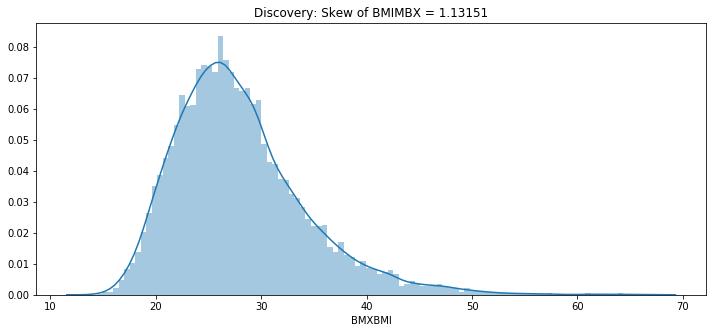

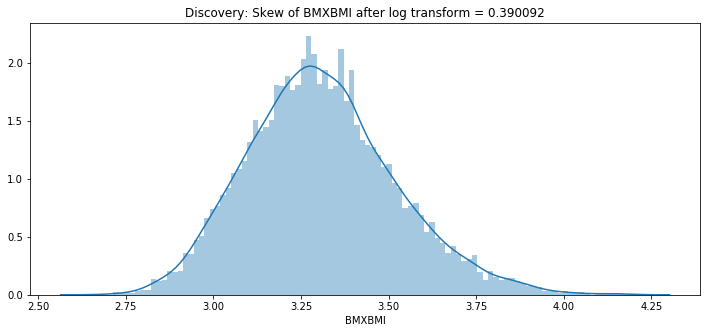

In [33]:
title = f"Discovery: Skew of BMIMBX = {stats.skew(discovery_final['BMXBMI']):.6}"
clarite.plot.histogram(discovery_final, column="BMXBMI", title=title, bins=100)
# Log-transform
discovery_final = clarite.modify.transform(discovery_final, transform_method='log', only='BMXBMI')
#Plot
title = f"Discovery: Skew of BMXBMI after log transform = {stats.skew(discovery_final['BMXBMI']):.6}"
clarite.plot.histogram(discovery_final, column="BMXBMI", title=title, bins=100)

Running transform
--------------------------------------------------------------------------------
Transformed 'BMXBMI' using 'log'


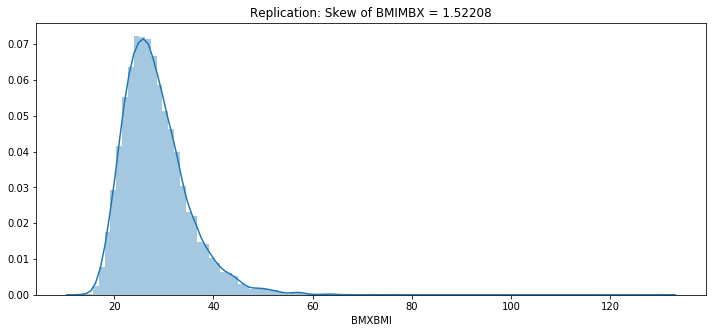

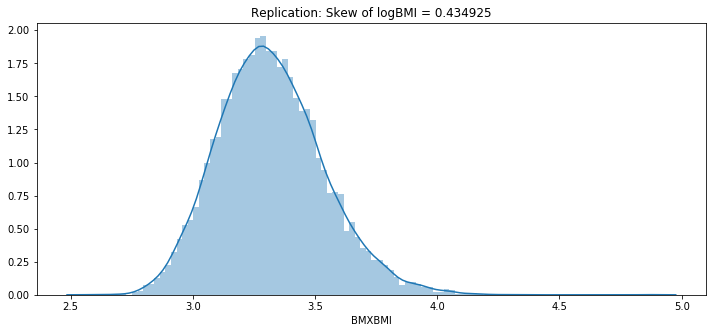

In [34]:
title = f"Replication: Skew of BMIMBX = {stats.skew(replication_final['BMXBMI']):.6}"
clarite.plot.histogram(replication_final, column="BMXBMI", title=title, bins=100)
# Log-transform
replication_final = clarite.modify.transform(replication_final, transform_method='log', only='BMXBMI')
#Plot
title = f"Replication: Skew of logBMI = {stats.skew(replication_final['BMXBMI']):.6}"
clarite.plot.histogram(replication_final, column="BMXBMI", title=title, bins=100)

## EWAS

### Survey Design Spec

When utilizing survey data, a survey design spec object must be created.

In [35]:
sd_discovery = clarite.survey.SurveyDesignSpec(survey_df=survey_design_discovery,
                                        strata="SDMVSTRA",
                                        cluster="SDMVPSU",
                                        nest=True,
                                        weights=weights_discovery,
                                        single_cluster='centered')

### EWAS

This can then be passed into the EWAS function

In [36]:
ewas_discovery = clarite.analyze.ewas(phenotype, covariates, discovery_final, sd_discovery)

Running on a continuous variable

####### Regressing 280 Continuous Variables #######




####### Regressing 48 Binary Variables #######


####### Regressing 4 Categorical Variables #######

Completed EWAS



There is a separate function for adding pvalues with multiple-test-correction applied.

In [38]:
clarite.analyze.add_corrected_pvalues(ewas_discovery)

Saving results is straightforward

In [39]:
ewas_discovery.to_csv(output + "/BMI_Discovery_Results.txt", sep="\t")

### Selecting top results

Variables with an FDR less than 0.1 were selected (using standard functionality from the Pandas library, since the ewas results are simply a Pandas DataFrame).

In [40]:
significant_discovery_variables = ewas_discovery[ewas_discovery['pvalue_fdr']<0.1].index.get_level_values('Variable')
print(f"Using {len(significant_discovery_variables)} variables based on FDR-corrected pvalues from the discovery dataset")

Using 100 variables based on FDR-corrected pvalues from the discovery dataset


## Replication

The variables with low FDR in the discovery dataset were analyzed in the replication dataset

### Filter out variables

In [41]:
keep_cols = list(significant_discovery_variables) + covariates + [phenotype]
replication_final_sig = clarite.modify.colfilter(replication_final, only=keep_cols)
clarite.describe.summarize(replication_final_sig)

Running colfilter
--------------------------------------------------------------------------------
Keeping 109 of 341 variables:
	19 of 54 binary variables
	3 of 5 categorical variables
	87 of 282 continuous variables
	0 of 0 unknown variables
9,874 observations of 109 variables
	19 Binary Variables
	3 Categorical Variables
	87 Continuous Variables
	0 Unknown-Type Variables



### Run Replication EWAS

In [42]:
survey_design_replication

,SDMVPSU,SDMVSTRA,WTINT2YR,...,WTSOG2YR,WTSC2YRA,WTSPC2YR
ID,,,,,,,
21005,2,39,2756.160474,...,NaN,NaN,NaN
21006,1,41,2711.070226,...,NaN,NaN,NaN
21007,2,35,19882.088706,...,NaN,NaN,NaN
21008,1,32,2799.749676,...,NaN,NaN,NaN
21009,2,31,48796.839489,...,NaN,NaN,NaN
...,...,...,...,...,...,...,...
41470,2,46,8473.426110,...,NaN,NaN,NaN
41471,1,52,3141.652775,...,9148.1015,NaN,NaN
41472,1,48,33673.789576,...,99690.8420,NaN,71892.249044


In [43]:
sd_replication = clarite.survey.SurveyDesignSpec(survey_df=survey_design_replication,
                                          strata="SDMVSTRA",
                                          cluster="SDMVPSU",
                                          nest=True,
                                          weights=weights_replication,
                                          single_cluster='centered')

ewas_replication = clarite.analyze.ewas(phenotype, covariates, replication_final_sig, sd_replication)
clarite.analyze.add_corrected_pvalues(ewas_replication)
ewas_replication.to_csv(output + "/BMI_Replication_Results.txt", sep="\t")

Running on a continuous variable

####### Regressing 85 Continuous Variables #######


####### Regressing 13 Binary Variables #######


####### Regressing 2 Categorical Variables #######

Completed EWAS



In [44]:
## Compare results

In [45]:
# Combine results
ewas_keep_cols = ['pvalue', 'pvalue_bonferroni', 'pvalue_fdr']
combined = pd.merge(ewas_discovery[['Variable_type'] + ewas_keep_cols],
                    ewas_replication[ewas_keep_cols],
                    left_index=True, right_index=True, suffixes=("_disc", "_repl"))

# FDR < 0.1 in both
fdr_significant = combined.loc[(combined['pvalue_fdr_disc'] <= 0.1) & (combined['pvalue_fdr_repl'] <= 0.1),]
fdr_significant = fdr_significant.assign(m=fdr_significant[['pvalue_fdr_disc', 'pvalue_fdr_repl']].mean(axis=1))\
                                 .sort_values('m').drop('m', axis=1)
fdr_significant.to_csv(output + "/Significant_Results_FDR_0.1.txt", sep="\t")
print(f"{len(fdr_significant)} variables had FDR < 0.1 in both discovery and replication")

# Bonferroni < 0.05 in both
bonf_significant05 = combined.loc[(combined['pvalue_bonferroni_disc'] <= 0.05) & (combined['pvalue_bonferroni_repl'] <= 0.05),]
bonf_significant05 = bonf_significant05.assign(m=fdr_significant[['pvalue_bonferroni_disc', 'pvalue_bonferroni_repl']].mean(axis=1))\
                                       .sort_values('m').drop('m', axis=1)
bonf_significant05.to_csv(output + "/Significant_Results_Bonferroni_0.05.txt", sep="\t")
print(f"{len(bonf_significant05)} variables had Bonferroni < 0.05 in both discovery and replication")

# Bonferroni < 0.01 in both
bonf_significant01 = combined.loc[(combined['pvalue_bonferroni_disc'] <= 0.01) & (combined['pvalue_bonferroni_repl'] <= 0.01),]
bonf_significant01 = bonf_significant01.assign(m=fdr_significant[['pvalue_bonferroni_disc', 'pvalue_bonferroni_repl']].mean(axis=1))\
                                       .sort_values('m').drop('m', axis=1)
bonf_significant01.to_csv(output + "/Significant_Results_Bonferroni_0.01.txt", sep="\t")
print(f"{len(bonf_significant01)} variables had Bonferroni < 0.01 in both discovery and replication")

bonf_significant01.head()

63 variables had FDR < 0.1 in both discovery and replication
16 variables had Bonferroni < 0.05 in both discovery and replication
10 variables had Bonferroni < 0.01 in both discovery and replication


,,Variable_type,pvalue_disc,pvalue_bonferroni_disc,...,pvalue_repl,pvalue_bonferroni_repl,pvalue_fdr_repl
Variable,Phenotype,,,,,,,
LBXGTC,BMXBMI,continuous,2.611467e-14,8.670071e-12,...,2.729179e-11,2.729179e-09,4.548631e-10
LBXIRN,BMXBMI,continuous,3.283440e-11,1.090102e-08,...,1.748424e-12,1.748424e-10,5.828079e-11
total_days_drink_year,BMXBMI,continuous,4.562887e-07,1.514879e-04,...,1.709681e-10,1.709681e-08,2.442402e-09
LBXBEC,BMXBMI,continuous,8.394013e-07,2.786812e-04,...,1.689733e-08,1.689733e-06,1.299795e-07
LBXCBC,BMXBMI,continuous,9.142106e-07,3.035179e-04,...,1.159283e-09,1.159283e-07,1.288093e-08


## Manhattan Plots

CLARITE provides functionality for generating highly customizable Manhattan plots from EWAS results

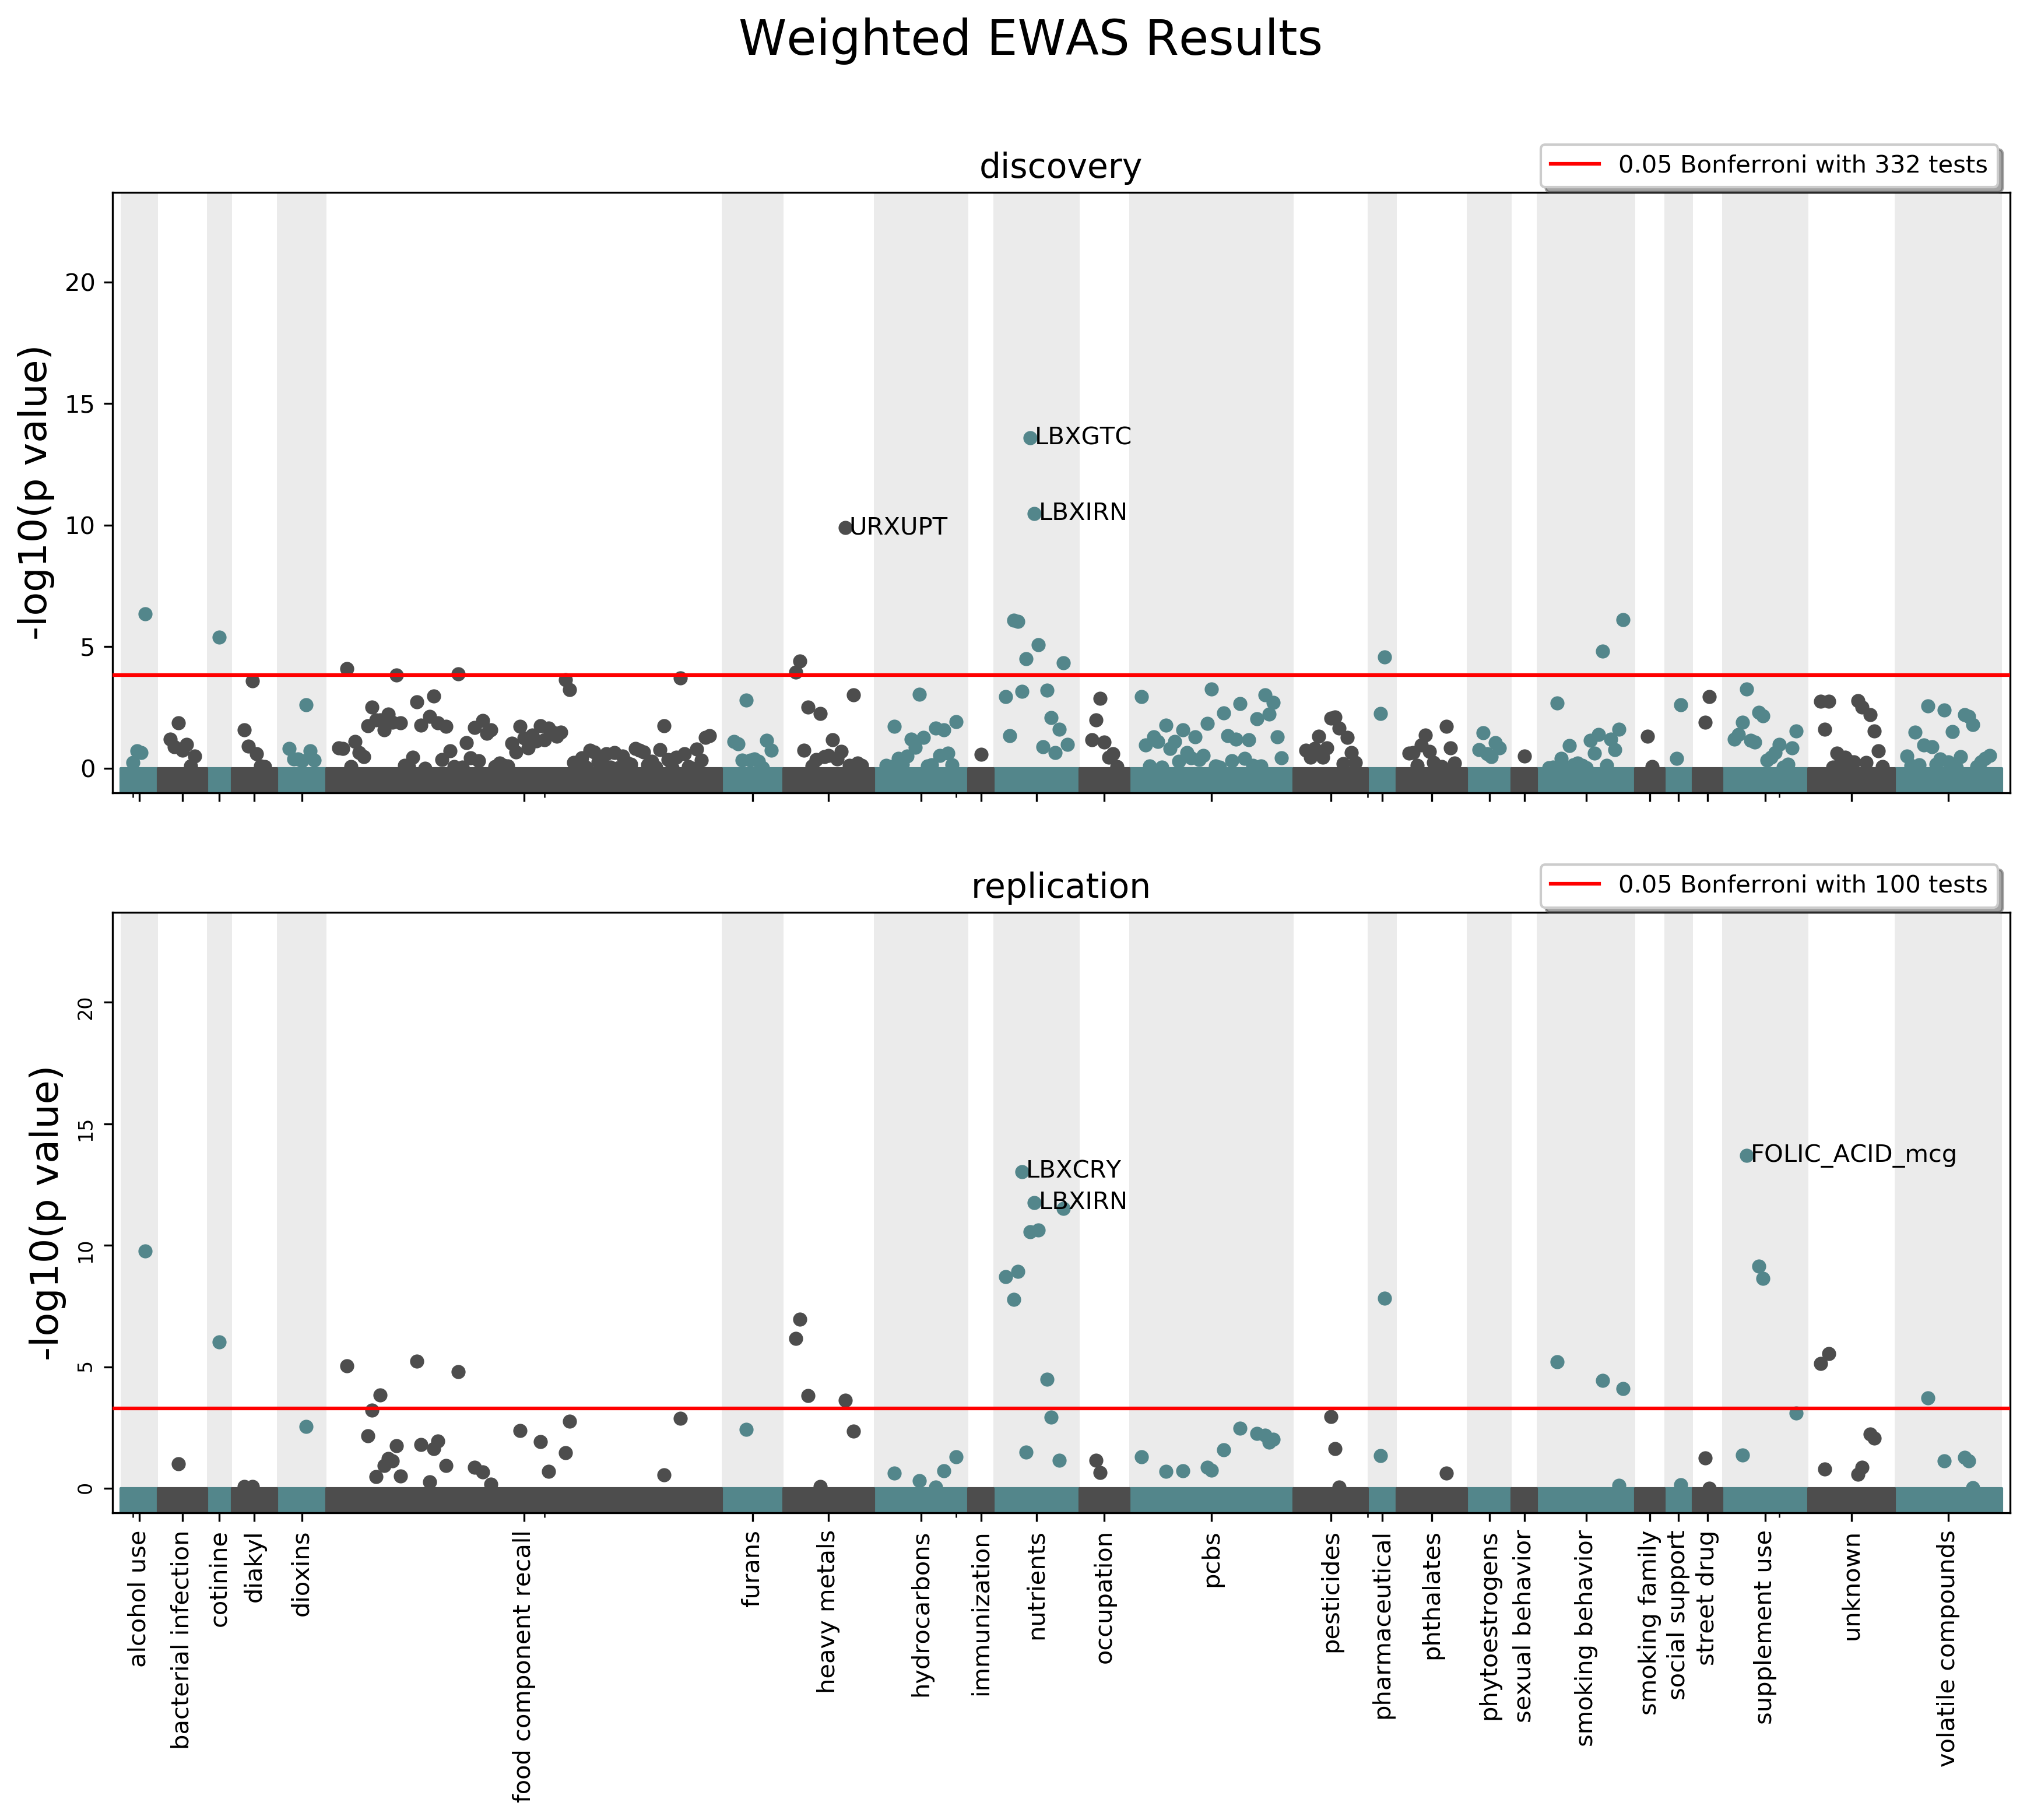

In [46]:
data_categories = pd.read_csv(data_var_categories, sep="\t").set_index('Variable')
data_categories.columns = ['category']
data_categories = data_categories['category'].to_dict()

clarite.plot.manhattan({'discovery': ewas_discovery, 'replication': ewas_replication},
                       categories=data_categories, title="Weighted EWAS Results", filename=output + "/ewas_plot.png",
                       figsize=(14, 10))